In [1]:
import tensorflow as tf
import os
import string
import io
import time
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

#This Notebook is based on the following Tensorflow Tutorial
#We used the general ideas of the tutorial and adapted it to our problem setting
#https://www.tensorflow.org/tutorials/text/nmt_with_attention

In [2]:
DIR_NAMES = ['train-easy/']
FILE_NAMES = ['calculus__differentiate.txt']

BUFFER_SIZE = 50000

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
dataset_dir = parent_dir + '/Dataset'

# Based on https://www.tensorflow.org/tutorials/load_data/text
# Read in all files which are in FILE_NAMES
labeled_data_sets = []

for file_name in FILE_NAMES:
    for dir_name in DIR_NAMES:
        concat_dir = os.path.join(dir_name, file_name)
        lines_dataset = io.open(os.path.join(dataset_dir, concat_dir), encoding='UTF-8').read().strip().split('\n')
        labeled_data_sets.append(lines_dataset)
        
# Concatenate all File Data to one Big File Data
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
    all_labeled_data = all_labeled_data.concatenate(labeled_dataset)
 
x_labels = all_labeled_data[::2]
y_labels = all_labeled_data[1::2]

MAX_QUESTION_LENGTH = 160
MAX_ANSWER_LENGTH = 30

#Build index for all characters which can appear, based on original code
QUESTION_CHARS = ( ['', ' '] + list(string.ascii_letters + string.digits + string.punctuation))
CHAR_TO_INDEX = {char: index for index, char in enumerate(QUESTION_CHARS)}
INDEX_TO_CHAR = {index: char for index, char in enumerate(QUESTION_CHARS)}

NUM_INDICES = len(QUESTION_CHARS)

#Encode the Data
x_labels_encoded = [[CHAR_TO_INDEX[z] for z in sentence] for sentence in x_labels]
y_labels_encoded = [[CHAR_TO_INDEX[z] for z in sentence] for sentence in y_labels]

In [3]:
print('Input Question')
print(x_labels[0])
print('Encoded Question')
print(x_labels_encoded[0])
print('Example Answer')
print(y_labels[0])
print('Encoded Answer')
print(y_labels_encoded[0])

Input Question
Find the first derivative of 2*d**4 - 35*d**2 - 695 wrt d.
Encoded Question
[33, 10, 15, 5, 1, 21, 9, 6, 1, 7, 10, 19, 20, 21, 1, 5, 6, 19, 10, 23, 2, 21, 10, 23, 6, 1, 16, 7, 1, 56, 73, 5, 73, 73, 58, 1, 76, 1, 57, 59, 73, 5, 73, 73, 56, 1, 76, 1, 60, 63, 59, 1, 24, 19, 21, 1, 5, 77]
Example Answer
8*d**3 - 70*d
Encoded Answer
[62, 73, 5, 73, 73, 57, 1, 76, 1, 61, 54, 73, 5]


In [4]:
#Padding the Input Questions and Output Answers to the right length
x_labels_padded = tf.keras.preprocessing.sequence.pad_sequences(x_labels_encoded, maxlen=MAX_QUESTION_LENGTH, value = 0, padding='post')
y_labels_padded = tf.keras.preprocessing.sequence.pad_sequences(y_labels_encoded, maxlen=MAX_ANSWER_LENGTH, value = 0, padding='post')

In [5]:
print('Padded Encoded Question')
print(x_labels_padded[0])
print('Padded Encoded Answer')
print(y_labels_padded[0])

Padded Encoded Question
[33 10 15  5  1 21  9  6  1  7 10 19 20 21  1  5  6 19 10 23  2 21 10 23
  6  1 16  7  1 56 73  5 73 73 58  1 76  1 57 59 73  5 73 73 56  1 76  1
 60 63 59  1 24 19 21  1  5 77  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Padded Encoded Answer
[62 73  5 73 73 57  1 76  1 61 54 73  5  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]


In [6]:
TAKE_SIZE = 100000
BUFFER_SIZE = 50000
BATCH_SIZE = 128
embedding_dim = 256
steps_per_epoch = TAKE_SIZE//BATCH_SIZE
units = 512

vocab_inp_size = NUM_INDICES
vocab_tar_size = NUM_INDICES

#Define how many (TAKE SIZE) labels we want to use to train and form batches of size BATCH_SIZE
dataset = tf.data.Dataset.from_tensor_slices((x_labels_padded, y_labels_padded)).take(TAKE_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [7]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [8]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

In [9]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [10]:
attention_layer = BahdanauAttention(10)

In [11]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [12]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

In [13]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  loss_ = loss_object(real, pred)
  return tf.reduce_mean(loss_)

In [14]:
checkpoint_dir = './new_calculus_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [15]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([CHAR_TO_INDEX['']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t-1], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t-1], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [16]:
TRAIN_FROM_CHECKPOINT = 0
SKIP_TRAINING = 1

latest_checkpoint_dir = './new_calculus_checkpoints'
if(TRAIN_FROM_CHECKPOINT):
    # restoring the latest checkpoint in checkpoint_dir
    checkpoint.restore(tf.train.latest_checkpoint(latest_checkpoint_dir))

if(not SKIP_TRAINING):
    EPOCHS = 60

    for epoch in range(EPOCHS):
      start = time.time()

      enc_hidden = encoder.initialize_hidden_state()
      total_loss = 0

      for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
          print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                       batch,
                                                       batch_loss.numpy()))
      # saving (checkpoint) the model every epochs

      checkpoint.save(file_prefix = checkpoint_prefix)

      print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                          total_loss / steps_per_epoch))
      print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

In [17]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  inputs = [[CHAR_TO_INDEX[z] for z in sentence]]
    
  inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                         maxlen=max_length_inp,
                                                         value=0,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([CHAR_TO_INDEX['']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += INDEX_TO_CHAR[predicted_id] #+ ' '

    if INDEX_TO_CHAR[predicted_id] == '':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [18]:
import random
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(30,30))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  random_number = random.random()
    
  #plt.savefig('calculus__differentiate_images/' + str(random_number) + '.png')
  #plt.savefig('calculus__differentiate_images/' + str(random_number) + '.pdf') 
  plt.show()

In [19]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(list(result)), :len(list(sentence))]
  plot_attention(attention_plot, list(sentence), list(result))

In [20]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

optimizer = tf.keras.optimizers.Adam()

checkpoint_dir = './best_arithmetic__add_or_sub_model'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

max_length_targ = MAX_ANSWER_LENGTH
max_length_inp = MAX_QUESTION_LENGTH
vocab_inp_size = NUM_INDICES
vocab_tar_size = NUM_INDICES

# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [21]:
#Predict and Check for Exact Match
def testing(testset):
    count = 0
    exact_match = 0
    for x, y in testset:
        x = x.numpy().decode("utf-8")
        y = y.numpy().decode("utf-8")

        result, sentence, attention_plot = evaluate(x)

        if(y == result):
            exact_match = exact_match + 1
        
        count = count + 1
        
    return exact_match/count

In [22]:
#Load in the train-medium and train-hard files (for extrapolation tests)

DIR_NAMES_MEDIUM = ['train-medium/']

DIR_NAMES_HARD = ['train-hard/']

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
dataset_dir = parent_dir + '/Dataset'

# Based on https://www.tensorflow.org/tutorials/load_data/text
# Read in all files which are in FILE_NAMES
labeled_data_sets = []

for file_name in FILE_NAMES:
    for dir_name in DIR_NAMES_MEDIUM:
        concat_dir = os.path.join(dir_name, file_name)
        lines_dataset = io.open(os.path.join(dataset_dir, concat_dir), encoding='UTF-8').read().strip().split('\n')
        labeled_data_sets.append(lines_dataset)
        
# Concatenate all File Data to one Big File Data
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
    all_labeled_data = all_labeled_data.concatenate(labeled_dataset)
 
x_labels_medium = all_labeled_data[::2]
y_labels_medium = all_labeled_data[1::2]

# Based on https://www.tensorflow.org/tutorials/load_data/text
# Read in all files which are in FILE_NAMES
labeled_data_sets = []

for file_name in FILE_NAMES:
    for dir_name in DIR_NAMES_HARD:
        concat_dir = os.path.join(dir_name, file_name)
        lines_dataset = io.open(os.path.join(dataset_dir, concat_dir), encoding='UTF-8').read().strip().split('\n')
        labeled_data_sets.append(lines_dataset)
        
# Concatenate all File Data to one Big File Data
all_labeled_data = labeled_data_sets[0]
for labeled_dataset in labeled_data_sets[1:]:
    all_labeled_data = all_labeled_data.concatenate(labeled_dataset)
 
x_labels_hard = all_labeled_data[::2]
y_labels_hard = all_labeled_data[1::2]

In [23]:
#Make small evaluation datasets
eval_train_set = tf.data.Dataset.from_tensor_slices((x_labels, y_labels)).take(100)
eval_test_set = tf.data.Dataset.from_tensor_slices((x_labels, y_labels)).skip(TAKE_SIZE).take(100)
eval_extrapolation_medium = tf.data.Dataset.from_tensor_slices((x_labels_medium, y_labels_medium)).take(100)
eval_extrapolation_hard = tf.data.Dataset.from_tensor_slices((x_labels_hard, y_labels_hard)).take(100)

basepath = './new_calculus_checkpoints/ckpt-'

In [24]:
#Loop through all checkpoints and test for train_set, test_set, extrapolation_medium, extrapolation_hard

NOW_EVALUATING = 0

if(NOW_EVALUATING):
    match_metric = []
    match_metric_test = []
    match_metric_extrapolation_medium = []
    match_metric_extrapolation_hard = []

    for i in range(1,31):
        ckppath = basepath + str(i)
        checkpoint.restore(ckppath)
        match_metric.append(testing(eval_train_set))
        match_metric_test.append(testing(eval_test_set))
        match_metric_extrapolation_medium.append(testing(eval_extrapolation_medium))
        match_metric_extrapolation_hard.append(testing(eval_extrapolation_hard))
        print(match_metric)
        print(match_metric_test)
        print(match_metric_extrapolation_medium)
        print(match_metric_extrapolation_hard)

In [25]:
#Load data from previous run
match_metric = [0.0, 0.04, 0.14, 0.35, 0.54, 0.51, 0.61, 0.65, 0.77, 0.76, 0.7, 0.78, 0.82, 0.75, 0.78, 0.85, 0.39, 0.86, 0.82, 0.91, 0.8, 0.91, 0.88, 0.91, 0.83, 0.82, 0.92, 0.93, 0.91, 0.93]
match_metric_test = [0.0, 0.09, 0.23, 0.39, 0.56, 0.55, 0.7, 0.74, 0.77, 0.75, 0.67, 0.79, 0.81, 0.74, 0.79, 0.82, 0.45, 0.85, 0.79, 0.86, 0.78, 0.88, 0.86, 0.88, 0.83, 0.76, 0.86, 0.87, 0.88, 0.9]
match_metric_extrapolation_medium = [0.0, 0.01, 0.09, 0.08, 0.17, 0.18, 0.25, 0.28, 0.34, 0.3, 0.31, 0.38, 0.43, 0.32, 0.36, 0.39, 0.13, 0.37, 0.31, 0.39, 0.35, 0.36, 0.37, 0.38, 0.41, 0.29, 0.38, 0.42, 0.38, 0.32]
match_metric_extrapolation_hard = [0.0, 0.0, 0.0, 0.0, 0.01, 0.04, 0.06, 0.0, 0.06, 0.06, 0.04, 0.09, 0.1, 0.05, 0.08, 0.12, 0.03, 0.11, 0.12, 0.12, 0.04, 0.08, 0.14, 0.17, 0.11, 0.11, 0.15, 0.18, 0.12, 0.13]

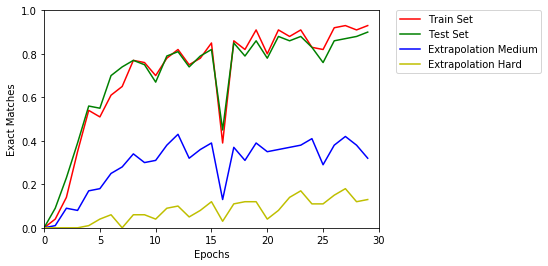

In [26]:
t = np.arange(0, 30, 1)

plt.xlabel('Epochs')
plt.ylabel('Exact Matches')
plt.plot(t, match_metric, "r", label="Train Set")
plt.plot(t, match_metric_test, "g", label="Test Set")
plt.plot(t, match_metric_extrapolation_medium, "b", label="Extrapolation Medium")
plt.plot(t, match_metric_extrapolation_hard, "y", label="Extrapolation Hard")
plt.axis([0, 30, 0, 1])
lgd = plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#plt.savefig('calculus__differentiate2.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
#plt.savefig('calculus__differentiate2.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

In [27]:
#Check which run is the best model for each case
#Best Model
print(match_metric.index(max(match_metric)))
print(match_metric_test.index(max(match_metric_test)))
print(match_metric_extrapolation_medium.index(max(match_metric_extrapolation_medium)))
print(match_metric_extrapolation_hard.index(max(match_metric_extrapolation_hard)))

27
29
12
27


Input: Find the first derivative of 2*d**4 - 35*d**2 - 695 wrt d.
Predicted translation: -682


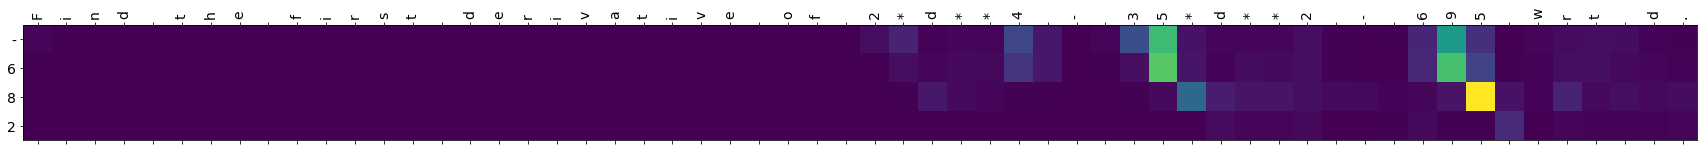

Input: Find the third derivative of -a**3*g**3*t**3 + 642*a**3*g*t**3 + 16*a**3*g*t**2 - 5*a**2*t**2 + a*g**3 wrt t.
Predicted translation: -426


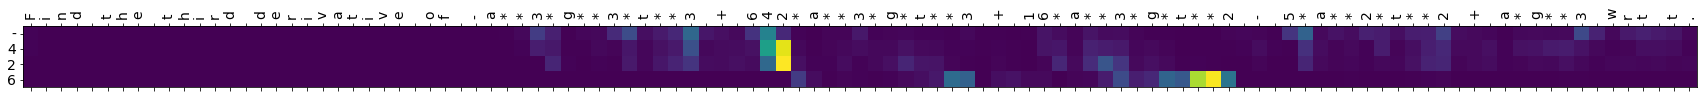

Input: What is the second derivative of 12518*f**3 + 3760*f?
Predicted translation: 13390


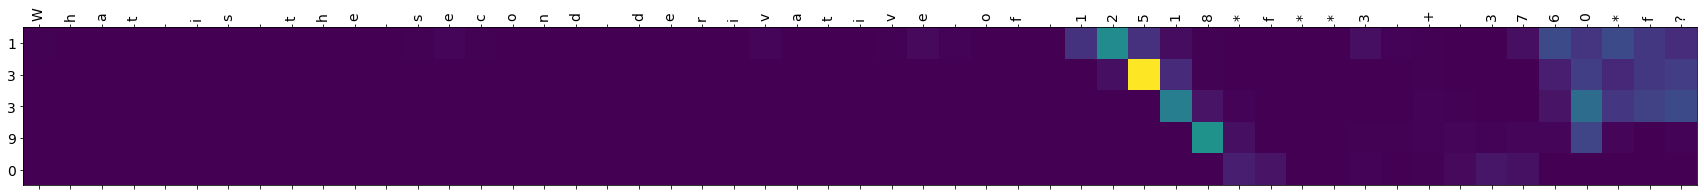

Input: What is the third derivative of -t**4 - 880*t**3 + 152*t**2 wrt t?
Predicted translation: -937


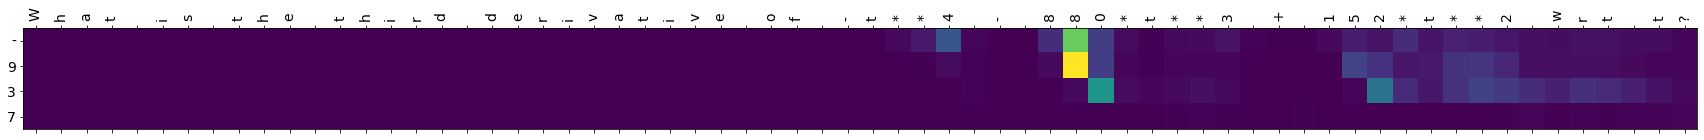

Input: What is the second derivative of 2*c*n**2*z**3 + 30*c*n**2 + 2*c*n*z**2 - 2*c + n**2*z**2 - 3*n*z**3 - 2*n*z wrt n?
Predicted translation: -43.3


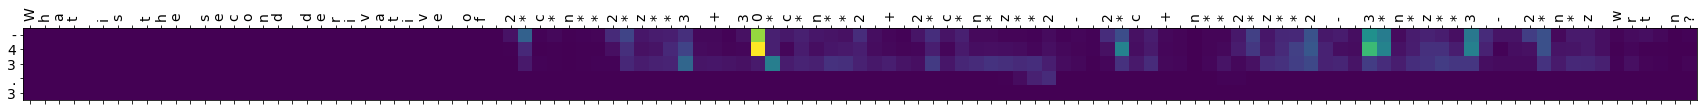

In [29]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

#Make sample predictions of Trainset and Evaluate
count = 0
for x, y in eval_train_set:
  x = x.numpy().decode("utf-8")
  y = y.numpy().decode("utf-8")
    
  translate(x)

  count = count + 1
  if(count == 5):
    break

Input: What is the derivative of -6*a**2*h*m - 122*a*h - h*m - 1317*m wrt a?
Predicted translation: -9154


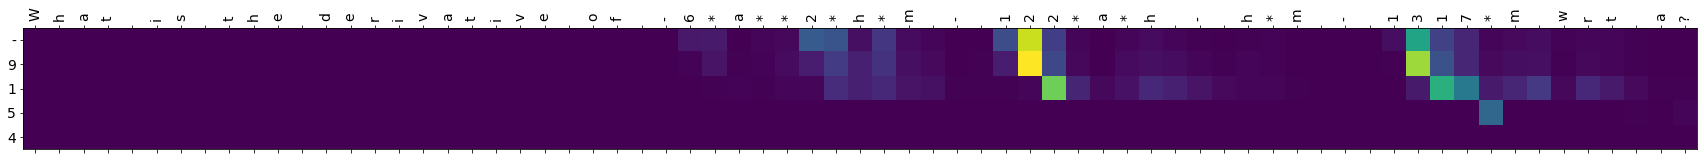

Input: Differentiate 68*k**2 - 4*k - 290.
Predicted translation: -222


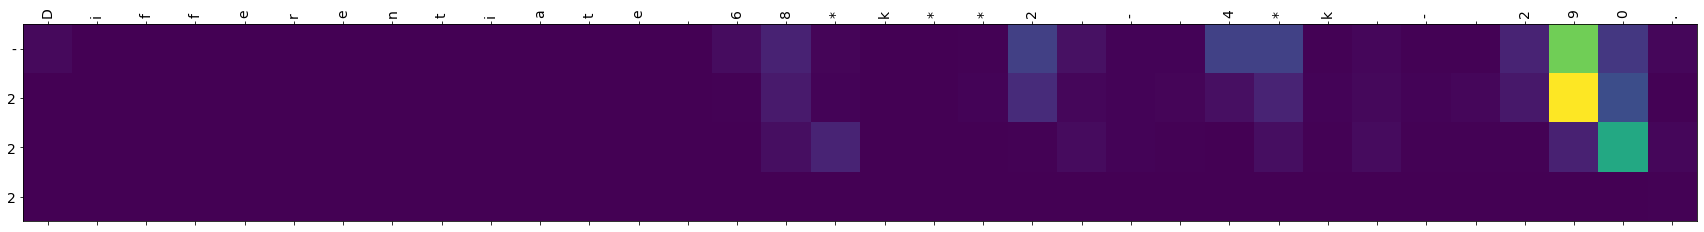

Input: Find the second derivative of 2*b*l**3*y**3 - 6*b*l**3 - 244*b*l**2*y**3 - b*l**2*y + b*l**2 - 10*l**3*y wrt y.
Predicted translation: -464


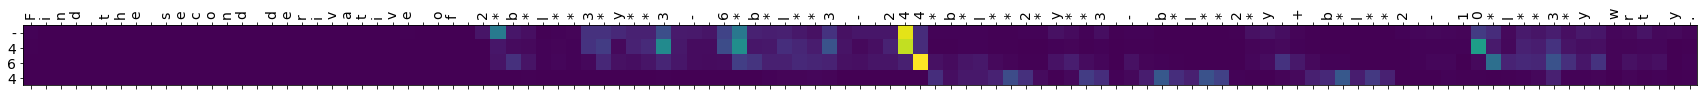

Input: What is the second derivative of -1825*y**4 - 164*y - 1 wrt y?
Predicted translation: -18363


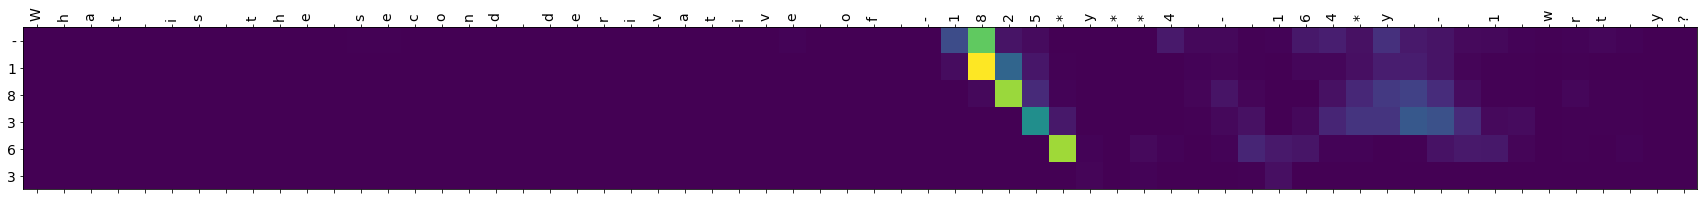

Input: Find the second derivative of 566*t**2 - 124*t wrt t.
Predicted translation: 688


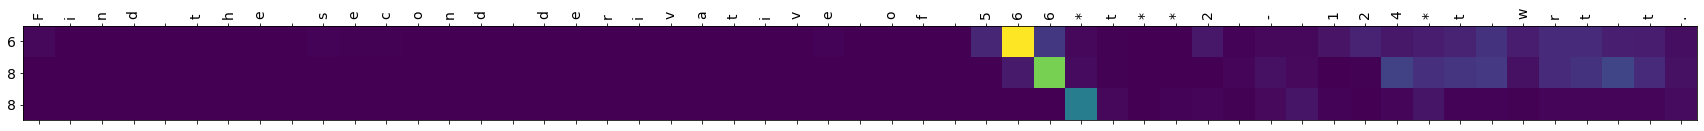

In [30]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

#Make sample predictions of Testset
count = 0
for x, y in eval_test_set:
  x = x.numpy().decode("utf-8")
  y = y.numpy().decode("utf-8")

  translate(x)

  count = count + 1
  if(count == 5):
    break

Input: Differentiate -186089*h**2 - 122007 with respect to h.
Predicted translation: -186198


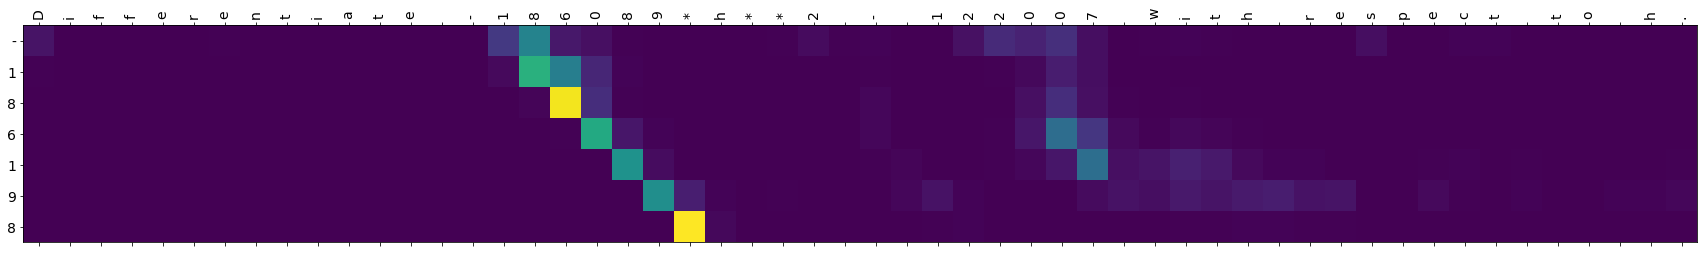

Input: What is the first derivative of 388896*d**3 - 222232?
Predicted translation: 288683


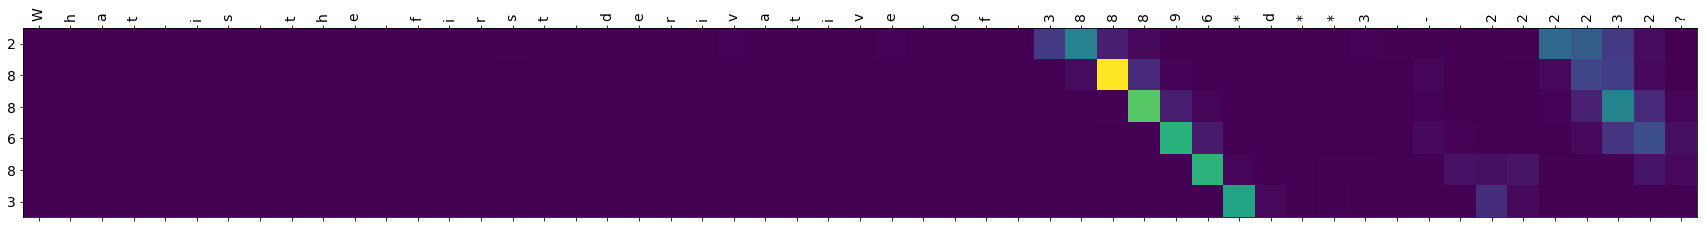

Input: Find the first derivative of -14*q**2 - 1003*q - 64537 wrt q.
Predicted translation: -10180


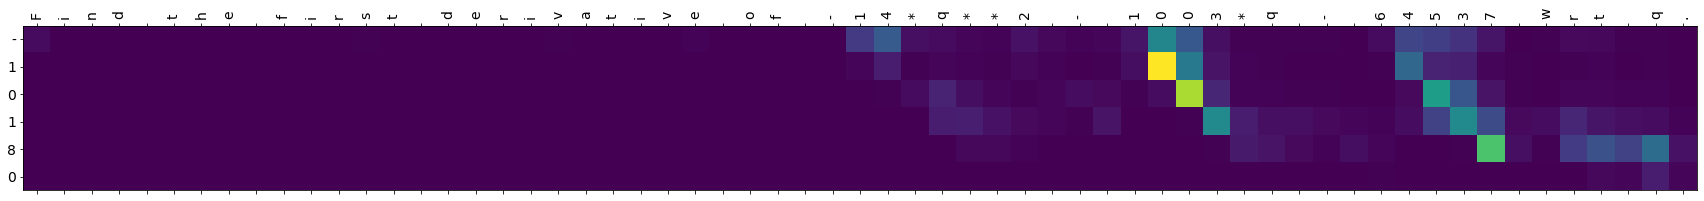

Input: Find the third derivative of -d*n**6 - 1787*d*n - 2*n**6 - 2007*n**3 + 17*n**2 wrt n.
Predicted translation: -17073


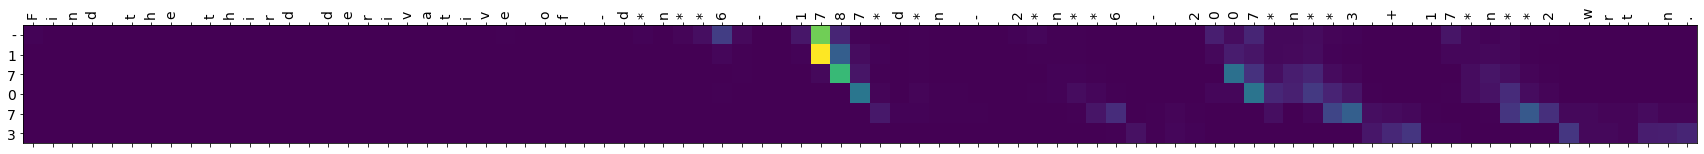

Input: What is the second derivative of -d**2*t*z - 94817*d**2*z - d**2 + 87*d*t*z + 6*d*z - 4*t*z - 2 wrt d?
Predicted translation: -95940


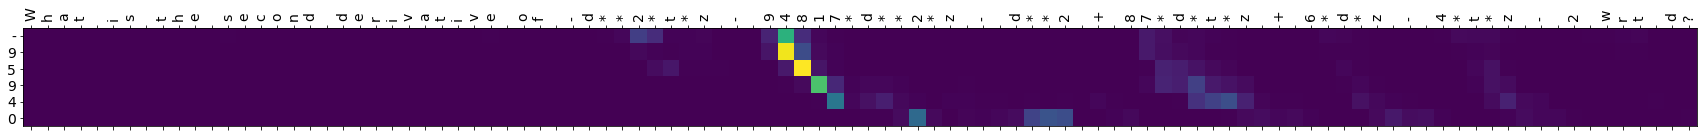

In [31]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

#Make sample predictions of Extrapolation Medium and plot it
count = 0
for x, y in eval_extrapolation_medium:
  x = x.numpy().decode("utf-8")
  y = y.numpy().decode("utf-8")

  translate(x)

  count = count + 1
  if(count == 5):
    break

Input: Find the third derivative of 178776*b**4 + 312*b**3 - 3594*b**2 + 68923*b wrt b.
Predicted translation: 188087


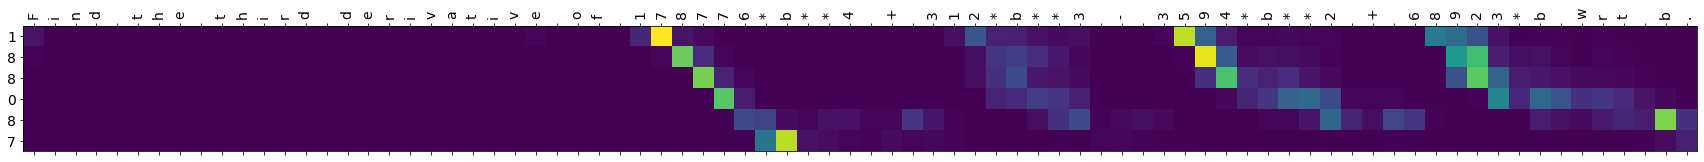

Input: Differentiate 214545431*i*q + 2*i + 2*q + 45166490 with respect to i.
Predicted translation: 31054490


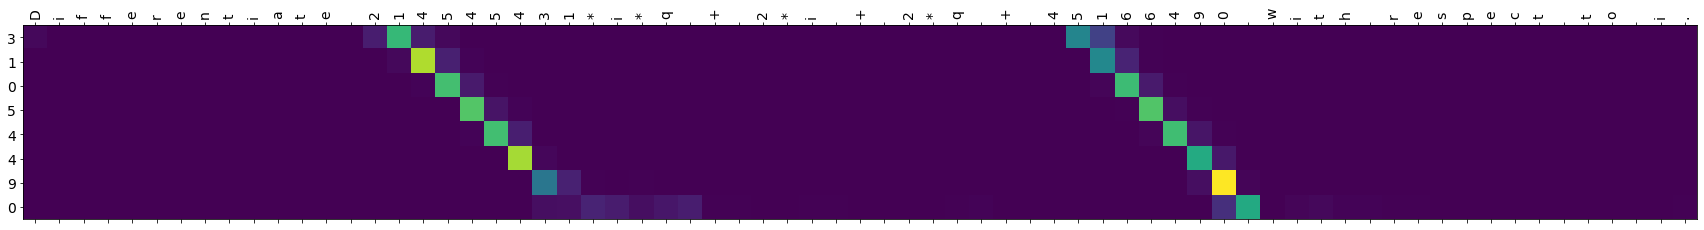

Input: Find the second derivative of q**5 - 391*q**4 + 1600*q**2 - 28211251*q.
Predicted translation: -9766623


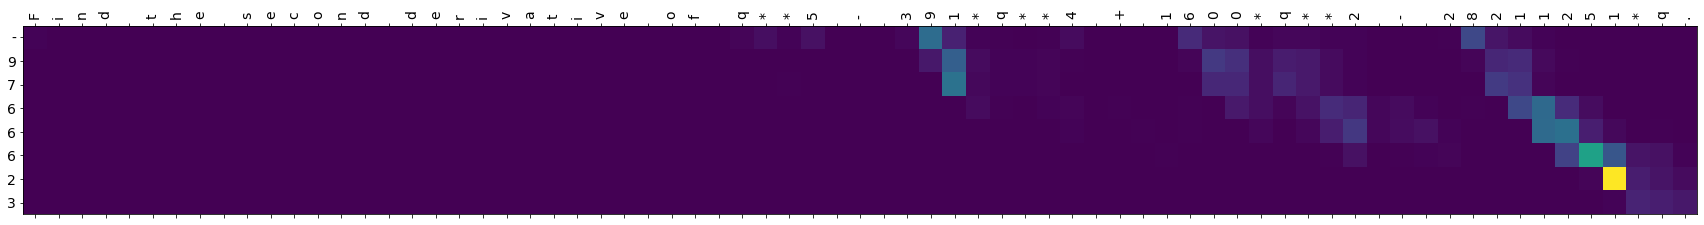

Input: Find the first derivative of -119078754*z - 159729822.
Predicted translation: -11997976


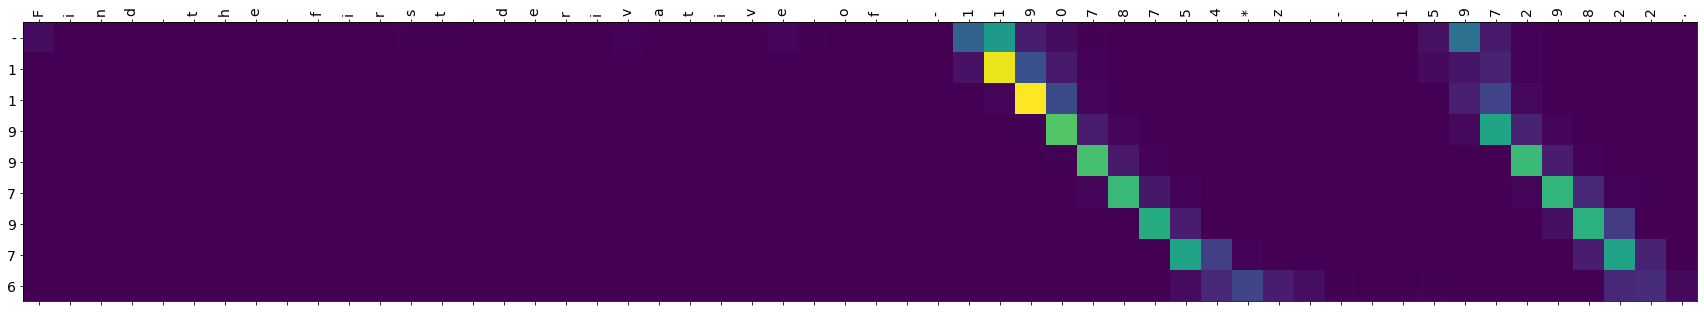

Input: Find the second derivative of -3*w**3*z + 56*w**3 - 23*w**2*z - 6093468*w*z wrt w.
Predicted translation: 4004476


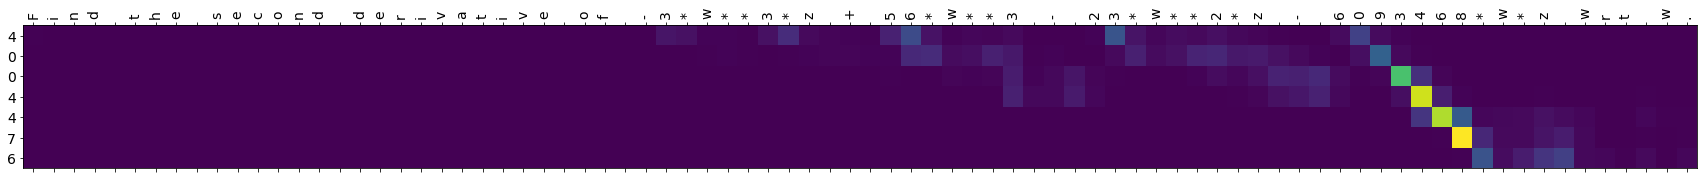

In [32]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

#Make sample predictions of Extrapolation Hard and plot it
count = 0
for x, y in eval_extrapolation_hard:
  x = x.numpy().decode("utf-8")
  y = y.numpy().decode("utf-8")
    
  translate(x)

  count = count + 1
  if(count == 5):
    break